# Geometric Datasets: Exeter

Improved version:
* F

## Description

Code for creating the geometric datasets for the Two-Objective Design/Resilience networks from [Exeter Benchmarks](https://emps.exeter.ac.uk/engineering/research/cws/resources/benchmarks/design-resiliance-pareto-fronts/) 

*Small Problems*
* Two-Reservoir Network
* Two-Loop Network
* BakRyan Network

*Medium Problems*
* New York Tunnel Network
* Blacksburg Network
* Hanoi Network

*Intemediate Problems*
* Fossolo Network
* Pescara Network

*Large Problems*
* Modena Network
* Balerma Irrigation Network

*GoYang Network and Exeter Network were excluded because they had accessories (Pumps and valves) not yet contemplated for the extent of this exercise. 


## Imports

### Basic

In [1]:
import os
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import winsound

### Custom functions

In [2]:
#Custom .py file
#from PrasadParkIndex import *
from res_index import *

### PyTorch and PyG

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
#from torch_geometric.datasets import TUDataset

C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### DeepSNAP

In [4]:
# from deepsnap.graph import Graph as dSNAP_Graph
# from deepsnap.dataset import GraphDataset as dSNAP_GraphDS

### Plotly

In [5]:
import plotly.graph_objects as go

## Loading inp file

In [6]:
# Create a water network model
def load_inp(inp_file_path):
    wn_WDS = wntr.network.WaterNetworkModel(inp_file_path)

    # Plot the network
    wntr.graphics.plot_network(wn_WDS, title=wn_WDS.name)

    # Simulate hydraulics
    sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
    results_WDS = sim_WDS.run_sim()
    
    return(wn_WDS, sim_WDS, results_WDS)

### Name of the Network 

Choices:
\['BAK', 'BIN', 'BLA', 'FOS', 'HAN', 'MOD', 'NYT', 'PES', 'TLN', 'TRN']

In [7]:
name_WDS = 'TRN'

#Read the Network info
WDS_info = pd.read_csv('./networks/Exeter/'+name_WDS+'_info.csv', dtype = {'NodeID': str} )

WDS_info.head()

,D,Cost,NodeID,MinPressure_m,UNITS_TO_M
0,0.152,49.54,2,28.18,1.0
1,0.203,63.32,3,17.61,NaN
2,0.254,94.82,4,35.22,NaN
3,0.305,132.87,6,35.22,NaN
4,0.356,170.93,7,35.22,NaN


In [8]:
#Transform the min. pressure of the nodes into a pandas dataframe
min_pres = WDS_info[['NodeID', 'MinPressure_m']].dropna()
min_pres = min_pres.set_index('NodeID')

#Obtain the conversion factor for the diameters (Some are given in inches, meters, or mm)
UNIT_TO_M = WDS_info['UNITS_TO_M'].dropna().item()

### Load the inp file

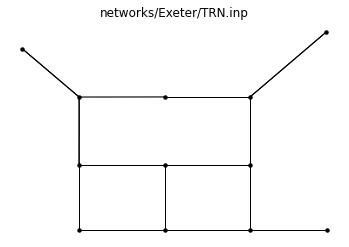

In [9]:
path= 'networks/Exeter/'+name_WDS+'.inp'
wn_WDS, _, _ = load_inp(path)
#wn_WDS = wntr.network.WaterNetworkModel(path)

In [10]:
names = ['BAK', 'BIN', 'BLA', 'FOS', 'HAN', 'MOD', 'NYT', 'PES', 'TLN', 'TRN']
seeds = [132, 65464, 8754, 465542, 13211, 9874545, 12, 9872, 6781, 978888]
dict_seeds =dict(zip(names, seeds))

num_pipes = wn_WDS.num_pipes

avail_diams = list(WDS_info.D.dropna()) #[6, 8, 10, 12, 14] #inches
pipe_names = wn_WDS.link_name_list

seed = dict_seeds[name_WDS] #Trial seed: 4345
np.random.seed(seed)



In [11]:
avail_diams

[0.152, 0.203, 0.254, 0.305, 0.356, 0.407, 0.458, 0.509]

## Dataset Creation

### NetworkX representation


Information on nodes and edges

In [12]:
def from_wntr_to_nx(wn):
    wn_links = list(wn.links())
    wn_nodes = list(wn.nodes())
    
    G_WDS = wn.get_graph() # directed multigraph
    uG_WDS = G_WDS.to_undirected() # undirected
    sG_WDS = nx.Graph(uG_WDS) #Simple graph  
    
    i=0
    for (u, v, wt) in sG_WDS.edges.data():
        assert isinstance(wn_links[i][1], wntr.network.elements.Pipe), "The link is not a pipe"
        sG_WDS[u][v]['diameter'] =  wn_links[i][1].diameter
        sG_WDS[u][v]['length'] =    wn_links[i][1].length
        sG_WDS[u][v]['roughness'] = wn_links[i][1].roughness
        i+=1
    
    i=0
    for u in sG_WDS.nodes:
        
        if sG_WDS.nodes[u]['type'] == 'Junction': 
            sG_WDS.nodes[u]['ID'] =          wn_nodes[i][1].name
            sG_WDS.nodes[u]['type_1H'] =     0
            sG_WDS.nodes[u]['base_demand'] = list(wn_nodes[i][1].demand_timeseries_list)[0].base_value
            sG_WDS.nodes[u]['elevation'] =   wn_nodes[i][1].elevation
            sG_WDS.nodes[u]['base_head'] =   0
            
            
        elif sG_WDS.nodes[u]['type'] == 'Reservoir':
            sG_WDS.nodes[u]['ID'] =          wn_nodes[i][1].name
            sG_WDS.nodes[u]['type_1H'] =     1
            sG_WDS.nodes[u]['base_demand'] = 0
            sG_WDS.nodes[u]['elevation'] =   0
            sG_WDS.nodes[u]['base_head'] =   wn_nodes[i][1].base_head
        else:
            print(u)
            raise Exception('Only Junctions and Reservoirs so far')
            break
            
        i+=1

    return sG_WDS #df_nodes, df_links, sG_WDS



In [13]:
#b = convert.from_networkx(a)

In [14]:
# def from_wntr_to_geometric(wn):      
#     df_nodes, df_links, sG_WDS = from_wntr_to_pandas(wn)   # get pandas dataframes

#     # create torch data 
#     x = torch.tensor(df_nodes[['node_type','base_demand','elevation','base_head']].astype(float).values, dtype=torch.float)
#     pos = torch.tensor(df_nodes['coords'], dtype=torch.float)
#     pg_sG_WDS = convert.from_networkx(sG_WDS)
    
#     #edge_index = torch.tensor(COO_edges, dtype=torch.long)
#     edge_attr = torch.tensor(df_links[['length','diameter','roughness']].astype(float).values, dtype=torch.float)
#     data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

#     return data, df_nodes, df_links

In [15]:
#data, df_nodes, df_links = from_wntr_to_geometric(wn_WDS)

In [16]:
#results_WDS.node['pressure']

In [17]:
# print(res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini'))

In [18]:
p = [(i+1)/len(avail_diams) for i in range(len(avail_diams))]
p = [p[i]/sum(p) for i in range(len(p))]

### Loop for database generation

In [19]:
#first_DB = []
np.random.seed(seed)

all_geom_data = [] # geometric data
fail_DB = []
N_iter = 5000
sim=0
while len(all_geom_data)<N_iter and len(fail_DB)<N_iter:
    # echo on screen
    if sim % 50 == 0 or sim == N_iter-1:
        print(f'iter: {sim}')
  
    # assign diameters    
    new_diams = np.random.choice(avail_diams, num_pipes, replace= True, p = p)
    new_diams = new_diams * UNIT_TO_M
    
    for i in range(num_pipes):
        c_pipe = wn_WDS.get_link(pipe_names[i])
        c_pipe.diameter = new_diams[i]
    
    # run the simulation
    try:
    # Simulate hydraulics
        sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
        results_WDS = sim_WDS.run_sim()
        flowrate = 0 #There are no pumps
        
        # get resilience indexes  
        RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
        RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')


        # create Geometric Data 
        data = convert.from_networkx(from_wntr_to_nx(wn_WDS))

        
        #Add resilience indexes
        data.res_Todini = torch.tensor(RI_Todini)
        data.res_PP = torch.tensor(RI_PP)
        all_geom_data.append(data)
    
    except Exception as e:
        fail_row = [sim]
        fail_row.append(np.round(new_diams/UNIT_TO_M, 0))
        fail_row.append(wn_WDS)
        fail_row.append(e)
        print(e)
        fail_DB.append(fail_row)
    sim+=1
    

iter: 0
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350
iter: 400
iter: 450
iter: 500
iter: 550
iter: 600
iter: 650
iter: 700
iter: 750
iter: 800
iter: 850
iter: 900
iter: 950
iter: 1000
iter: 1050
iter: 1100
iter: 1150
iter: 1200
iter: 1250
iter: 1300
iter: 1350
iter: 1400
iter: 1450
iter: 1500
iter: 1550
iter: 1600
iter: 1650
iter: 1700
iter: 1750
iter: 1800
iter: 1850
iter: 1900
iter: 1950
iter: 2000
iter: 2050
iter: 2100
iter: 2150
iter: 2200
iter: 2250
iter: 2300
iter: 2350
iter: 2400
iter: 2450
iter: 2500
iter: 2550
iter: 2600
iter: 2650
iter: 2700
iter: 2750
iter: 2800
iter: 2850
iter: 2900
iter: 2950
iter: 3000
iter: 3050
iter: 3100
iter: 3150
iter: 3200
iter: 3250
iter: 3300
iter: 3350
iter: 3400
iter: 3450
iter: 3500
iter: 3550
iter: 3600
iter: 3650
iter: 3700
iter: 3750
iter: 3800
iter: 3850
iter: 3900
iter: 3950
iter: 4000
iter: 4050
iter: 4100
iter: 4150
iter: 4200
iter: 4250
iter: 4300
iter: 4350
iter: 4400
iter: 4450
iter: 4500
iter: 4550
iter: 4600


In [20]:
print(len(all_geom_data), len(fail_DB))

5000 0


In [21]:
all_geom_data[-1]

Data(ID=[12], base_demand=[12], base_head=[12], diameter=[28], edge_index=[2, 28], elevation=[12], length=[28], pos=[12, 2], res_PP=[1], res_Todini=[1], roughness=[28], type=[28], type_1H=[12])

In [22]:
winsound.Beep(1000, 500)

In [23]:
# folder
dir_path = os.getcwd()+'\{name}_Geom_DB_{num_iter}'.format(name = name_WDS, num_iter = N_iter)
print(dir_path)

C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\TRN_Geom_DB_5000


In [24]:
dataset = {}
dataset['info'] = 'Dataset for graph regression to compute '+name_WDS+' resilience index. Edge_attr = [Length, diameter, roughness] of every pipe, x =[Node type(junction 0, reservoir 1), Base demand (0 for reservoirs), elevation, base head(0 for junctions)]'
dataset['ngraphs'] = len(all_geom_data)
dataset['data'] = all_geom_data

In [25]:
# save
try:
    os.mkdir(dir_path)    
    pickle.dump(dataset,open(f"{dir_path}/{name_WDS}_dataset.p", "wb" ))
except OSError:
    print ("Creation of the directory %s failed" % dir_path)
else:
    print ("Successfully created the directory %s " % dir_path)

Successfully created the directory C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\TRN_Geom_DB_5000 


In [26]:
# save
# try:
#     #os.mkdir(dir_path)    
#     pickle.dump(dataset,open(f"{dir_path}/{name_WDS}_dataset2.p", "wb" ))
# except OSError:
#     print ("Creation of the directory %s failed" % dir_path)
# else:
#     print ("Successfully created the directory %s " % dir_path)

In [27]:
#pickle.dump(dataset,open(f"{dir_path}/{name_WDS}_dataset.p", "wb" ))

In [28]:
#prueba = pickle.load(open(r'C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\BIN_Geom_DB_5000\BIN_dataset.p', 'rb'))

In [29]:
prueba = pickle.load(open(f'{dir_path}/{name_WDS}_dataset.p', 'rb'))

In [30]:
len(prueba['data'])

5000

In [31]:
res = []
neg =0
pos =0
for i in range(len(prueba['data'])):
    valueRes = prueba['data'][i].res_PP
    res.append(valueRes)
    if valueRes <0:
        neg+=1
    else:
        pos+=1
    

In [33]:
pos, neg

(4996, 4)

In [34]:
#RI_PP_new = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
#RI_Todini_new = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
#RI_PP_old = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 30)
#RI_Todini_old = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 30)

In [35]:
#RI_Todini_new, RI_PP_old

In [36]:
np.array(res).max(), np.array(res).min()

(0.6304261328608232, -0.1365811470703154)

In [37]:
#RI_PP_old

In [38]:
#RI_PP_new

In [39]:
#     RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
#     RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
    #RI_PP = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    #RI_Todini = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)

In [40]:
res[0:10]

[tensor([0.3111], dtype=torch.float64),
 tensor([0.3955], dtype=torch.float64),
 tensor([0.3077], dtype=torch.float64),
 tensor([0.3386], dtype=torch.float64),
 tensor([0.4957], dtype=torch.float64),
 tensor([0.2374], dtype=torch.float64),
 tensor([0.3236], dtype=torch.float64),
 tensor([0.2477], dtype=torch.float64),
 tensor([0.0541], dtype=torch.float64),
 tensor([0.4595], dtype=torch.float64)]

In [41]:
prueba['data'][4997].diameter #Diameters

tensor([0.5090, 0.4070, 0.5090, 0.4070, 0.3560, 0.3560, 0.2030, 0.4580, 0.5090,
        0.3560, 0.4580, 0.3560, 0.4070, 0.5090, 0.2030, 0.5090, 0.3050, 0.4580,
        0.4580, 0.4070, 0.4580, 0.4580, 0.3050, 0.4580, 0.3050, 0.3050, 0.5090,
        0.4580], dtype=torch.float64)

In [42]:
prueba['data'][0].diameter/ UNIT_TO_M #Diameters

tensor([0.4070, 0.4580, 0.4070, 0.4580, 0.4070, 0.4070, 0.5090, 0.3050, 0.4070,
        0.5090, 0.5090, 0.5090, 0.3050, 0.5090, 0.5090, 0.5090, 0.3560, 0.5090,
        0.5090, 0.3050, 0.5090, 0.5090, 0.3560, 0.5090, 0.2540, 0.2540, 0.4070,
        0.3050], dtype=torch.float64)